# Project: Investigate a Dataset (Replace this with something more specific!)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> **Tip**: In this section of the report, provide a brief introduction to the dataset you've selected for analysis. At the end of this section, describe the questions that you plan on exploring over the course of the report. Try to build your report around the analysis of at least one dependent variable and three independent variables.
>
> If you haven't yet selected and downloaded your data, make sure you do that first before coming back here. If you're not sure what questions to ask right now, then make sure you familiarize yourself with the variables and the dataset context for ideas of what to explore.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")

<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you document your steps carefully and justify your cleaning decisions.

### General Properties

In [128]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
df_nics = pd.read_excel('gun_data.xlsx')
df_census = pd.read_csv('U.S. Census Data.csv')

The data comes from the FBI's National Instant Criminal Background Check System. The NICS is used to determine whether a prospective buyer is eligible to buy firearms or explosives. Gun shops call into this system to ensure that each customer does not have a criminal record or isn’t otherwise ineligible to make a purchase. The data has been supplemented with state level data from census.gov.

The NICS data is found in one sheet of an .xlsx file. 
The U.S. census data is found in a .csv file. 
https://github.com/BuzzFeedNews/nics-firearm-background-checks/blob/master/README.md
Other (column) = Refers to frames, receivers and other firearms that are not either handguns or long guns (rifles or shotguns), such as firearms having a pistol grip that expel a shotgun shell
Multiple (column) = Multiple (multiple types of firearms selected)
DISCLAIMERS:
Some states may reflect lower than expected numbers for handgun checks based on varying state laws pertaining to handgun permits. Since the permit check is done in place of the NICS check in most of the affected states, the low handgun statistics are often balanced out by a higher number of handgun permit checks

##### df_gun
- Contains the number of firearm checks by month, state, and type.
- 12,485 rows, 27 columns
- Majority of columns contain null values.
- Columns without null values: month, state, multiple, totals
- 0 duplicate rows
- month and state columns are strings, mutiple and totals columns are integers, remaining columns are floats

##### df_census
- Contains several variables at the state level. Most variables just have one data point per state (2016), but a few have data for more than one year.
- 85 rows, 52 columns (one column for each state plus a fact and fact note column)
- 3 duplicate rows - all columns contain null values
- All columns are strings, but values are floats, integers, or percentages

In [129]:
#display(df_nics.shape)
#display(df_nics.info())
#df_nics.head()

In [130]:
#display(df_census.shape)
#display(df_census.info())
#df_census.head()

> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.

> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).

### Data Cleaning (Replace this with more specific notes!)

##### NICS data
1. Remove state values that do not appear in the columns of the census data ('District of Columbia', 'Guam', 'Mariana Islands', 'Puerto Rico','Virgin Islands')
2. Check that the month and state columns did not have null values
3. Filled null values with 0.0
4. turned all float columns to integers, for consistency
5. Creates a year column
6. Remove unnecessary columns based - based on information from http://www.smallarmssurvey.org/fileadmin/docs/F-Working-papers/SAS-WP14-US-Firearms-Industry.pdf 

In [131]:
original = df_nics.shape[0]
#replace NAs with 0s
df_nics.fillna(0.0,inplace=True)

df_nics['handgun_totals'] = (df_nics.handgun + df_nics.prepawn_handgun + 
                             df_nics.redemption_handgun + df_nics.returned_handgun + df_nics.rentals_handgun + 
                             df_nics.private_sale_handgun + df_nics.return_to_seller_handgun)
df_nics['long_gun_totals'] = (df_nics.long_gun + df_nics.prepawn_long_gun + df_nics.redemption_long_gun + 
                              df_nics.returned_long_gun + df_nics.rentals_long_gun + df_nics.private_sale_long_gun + 
                              df_nics.return_to_seller_long_gun)

#remove columns that are not relevant
keep_cols = ['month', 'state', 'multiple', 'handgun_totals', 'long_gun_totals']
remove=[]
for col in list(df_nics.columns):
    if not col in keep_cols:
        remove.append(col)
df_nics.drop(remove, axis=1, inplace=True)

#new columns
df_nics['all_totals'] = df_nics.handgun_totals + df_nics.long_gun_totals + df_nics.multiple
df_nics['sales_estimate'] = 1.1 * (df_nics.handgun_totals + df_nics.long_gun_totals + df_nics.multiple * 2) #MGSF

#filter df_gun to only values that could be tied to the columns of the census data
state_list = list(df_census.columns[2:]) #list of states from census columns
remove_vals = df_nics.query('not state in {}'.format(state_list))
df_nics.drop(remove_vals.index, inplace=True)

#turn all columns to integers for consistency
for col in df_nics.columns[2:]:
    df_nics[col] = df_nics[col].astype(int)

#display(removed.state.unique())
print('Rows removed: ', str(original - df_nics.shape[0]))

df_nics.reset_index(inplace=True, drop=True)    
df_nics['year'] = df_nics['month'].apply(lambda x: x[:4])
df_nics = df_nics.query('not year in {}'.format(['1998', '2017']))

Rows removed:  1135


##### Census data
Steps:
1. Remove duplicates / null rows
2. Remove rows with all null values
3. Turn columns of each state into floats from strings
4. Creates a year column

In [132]:
#identifies and removes extra rows of information that include notes 
df_census_extra = df_census.iloc[64:,:] 
df_census.drop(df_census_extra.index,inplace=True)

census_t = df_census.transpose(copy=True)
census_t.head()
headers = census_t.iloc[0,:]
census_t.columns = headers

census_t.drop_duplicates(inplace=True)
census_t.drop(['Fact', 'Fact Note'],axis=0,inplace=True)
census_t.fillna("0",inplace=True)
census_t.head(1)

Fact,"Population estimates, July 1, 2016, (V2016)","Population estimates base, April 1, 2010, (V2016)","Population, percent change - April 1, 2010 (estimates base) to July 1, 2016, (V2016)","Population, Census, April 1, 2010","Persons under 5 years, percent, July 1, 2016, (V2016)","Persons under 5 years, percent, April 1, 2010","Persons under 18 years, percent, July 1, 2016, (V2016)","Persons under 18 years, percent, April 1, 2010","Persons 65 years and over, percent, July 1, 2016, (V2016)","Persons 65 years and over, percent, April 1, 2010",...,"Total nonemployer establishments, 2015","All firms, 2012","Men-owned firms, 2012","Women-owned firms, 2012","Minority-owned firms, 2012","Nonminority-owned firms, 2012","Veteran-owned firms, 2012","Nonveteran-owned firms, 2012","Population per square mile, 2010","Land area in square miles, 2010"
Alabama,"4,863,300","4,780,131",1.70%,"4,779,736",6.00%,6.40%,22.60%,23.70%,16.10%,13.80%,...,"322,025","374,153","203,604","137,630","92,219","272,651","41,943","316,984",94.4,"50,645.33"


In [133]:
val_flags = ['-','D','F','FN','NA','S','X','Z'] #value flags found in bottom of data.
census_t.replace(to_replace=val_flags, value="0", inplace=True) #replace all value flags with 0

for col in census_t.columns:
    #first, if a value in a column has  a % sign, remove it and divide it by 100, else remove all commas and $
    census_t[col] = census_t[col].apply(lambda x: x.replace(',','').replace('$','').replace('%',''))
    census_t[col] = census_t[col].astype(float) #turn all state columns to floats


In [134]:
census_t['employment%_2015'] = census_t['Total employment, 2015'] / census_t['Population estimates, July 1, 2016,  (V2016)']

census_t['veterans%_2015'] = census_t['Veterans, 2011-2015'] / census_t['Population estimates, July 1, 2016,  (V2016)']

keep_dict = {'Population estimates, July 1, 2016,  (V2016)': 'population_2016',
             'Population estimates base, April 1, 2010,  (V2016)': 'population_2010',
             'Persons 65 years and over, percent,  July 1, 2016,  (V2016)': '65+%_2016',
             'High school graduate or higher, percent of persons age 25 years+, 2011-2015': 'highschool+%_2015',
             "Bachelor's degree or higher, percent of persons age 25 years+, 2011-2015": 'bachelors+%_2015',
             'Median household income (in 2015 dollars), 2011-2015': 'median_income_2015',
             'Population per square mile, 2010': 'pop_per_sqmile_2010',
             'employment%_2015': 'employment%_2015',
             'veterans%_2015': 'veterans%_2015'}

remove_cols = []
for col in list(census_t.columns):
    if not col in list(keep_dict.keys()):
        remove_cols.append(col)
        
census_t.drop(remove_cols, axis=1, inplace=True)

census_t.rename(columns=keep_dict, inplace=True)

#fact notes found at the bottom of the data
#notes = {'(a)':'Includes persons reporting only one race', 
         #'(b)':'Hispanics may be of any race, so also are included in applicable race categories', 
         #'(c)':'Economic Census - Puerto Rico data are not comparable to U.S. Economic Census data'}

#replace the keys from the notes dict with their values within the Fact Note column
#census_t['Fact Note'].replace(notes, inplace=True)



In [135]:
census_t.head()

Fact,population_2016,population_2010,65+%_2016,highschool+%_2015,bachelors+%_2015,median_income_2015,pop_per_sqmile_2010,employment%_2015,veterans%_2015
Alabama,4863300.0,4780131.0,16.1,84.3,23.5,43623.0,94.4,0.336066,0.074676
Alaska,741894.0,710249.0,10.4,92.1,28.0,72515.0,1.2,0.361236,0.093441
Arizona,6931071.0,6392301.0,16.9,86.0,27.5,50255.0,56.3,0.331144,0.072975
Arkansas,2988248.0,2916025.0,16.3,84.8,21.1,41371.0,56.0,0.335686,0.073941
California,39250017.0,37254522.0,13.6,81.8,31.4,61818.0,239.1,0.364978,0.045284


In [136]:
#extracts the year from the month column and creates a year column

#min_year = int(df_nics.year.unique().min())
#max_year = int(df_nics.year.unique().max())
#year_list = list(range(max_year, min_year-1, -1))

#display(df_nics.info())

#extracts the highest year in the Fact row and creates a year column
#df_census['year']= 0
#for i, v in df_census['Fact'].items():
    #for year in year_list:
        #if str(year) in v:
            #df_census.loc[i, 'year'] = year
            
#df_census.info()

# After discussing the structure of the data and any problems that need to be
#   cleaned, perform those cleaning steps in the second part of this section.

<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.



### How have guns sales changed over time?

In [156]:
nics_year= df_nics.groupby(['year'], as_index=False).sum()

nics_month = df_nics.groupby(['month'], as_index=False).sum()

nics_state = df_nics.groupby(['state'], as_index=False, sort=False).sum().sort_values(by='sales_estimate', ascending=False)



0      87515040
1      78732060
2      81408260
3      77123610
4      77212180
5      80035870
6      83639090
7      88374610
8      92080850
9     100750820
10    107027320
11    105019740
12    120068200
13    152048250
14    162792730
15    143247820
16    155412620
17    169577880
Name: sales_estimate, dtype: int64

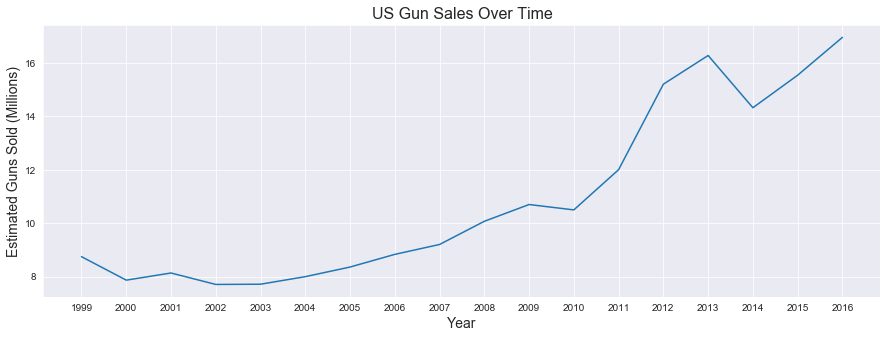

In [159]:
f, (ax1) = plt.subplots(1,1, figsize=(15,5))

ax1.plot(nics_year.year, nics_year.sales_estimate/1000000) #estimates in millions
ax1.set_ylabel('Estimated Guns Sold (Millions)', fontsize=14)
ax1.set_title('US Gun Sales Over Time', fontsize=16);


### What are the top 5 state in guns per capita? And how has this changed over time?

In [139]:
nics_year_state = df_nics.groupby(['year','state'], as_index=False, sort=False).sum()

In [140]:
def create_merge(year):
    
    merged = nics_year_state.query('year == "{}"'.format(year)).merge(census_t, how="inner", left_on='state', right_index=True).drop('year',axis=1)
    merged['sold_per_capita'] = merged.sales_estimate / merged['population_{}'.format(year)]
    merged.sort_values('sold_per_capita', ascending=False, inplace=True)
    merged.reset_index(drop=True, inplace=True)
    
    return merged

merged_2016 = create_merge('2016')
merged_2010 = create_merge('2010')


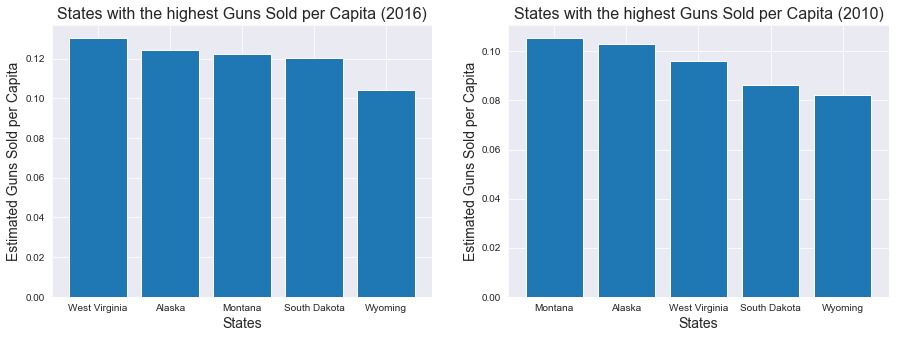

In [141]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.bar(merged_2016.state[:5], merged_2016.sold_per_capita[:5]) #top 5
ax1.set_xlabel('States', fontsize=14)
ax1.set_ylabel('Estimated Guns Sold per Capita', fontsize=14)
ax1.set_title('States with the highest Guns Sold per Capita (2016)', fontsize=16)

ax2.bar(merged_2010.state[:5], merged_2010.sold_per_capita[:5]) #top 5
ax2.set_xlabel('States', fontsize=14)
ax2.set_ylabel('Estimated Guns Sold per Capita', fontsize=14)
ax2.set_title('States with the highest Guns Sold per Capita (2010)', fontsize=16);

### Which states have had the highest growth in guns sold from 2010-2016, per capita?

In [144]:
merged_2016['sales_chg_10to16'] = (merged_2016.sales_estimate - merged_2010.sales_estimate) / merged_2016.population_2010

sorted_merge = merged_2016.sort_values(by='sales_chg_10to16', ascending=False)


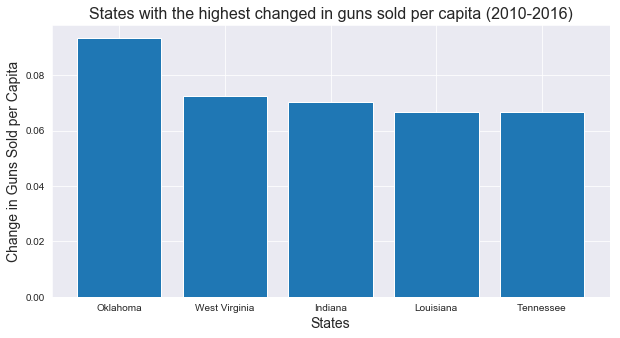

In [145]:
f, (ax1) = plt.subplots(1,1, figsize=(10,5))

ax1.bar(sorted_merge.state[:5], sorted_merge.sales_chg_10to16[:5]) #top 5
ax1.set_xlabel('States', fontsize=14)
ax1.set_ylabel('Change in Guns Sold per Capita', fontsize=14)
ax1.set_title('States with the highest changed in guns sold per capita (2010-2016)', fontsize=16);

### What census data is most associated with high gun per capita? 

In [ ]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.



### gg 

In [ ]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.


### What is the overall trend of gun purchases?

<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed. Make sure that you are clear with regards to the limitations of your exploration. If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work, you should save a copy of the report in HTML or PDF form via the **File** > **Download as** submenu. Before exporting your report, check over it to make sure that the flow of the report is complete. You should probably remove all of the "Tip" quotes like this one so that the presentation is as tidy as possible. Congratulations!